# Inlämningsuppgift: Del 2 - Adversarial input attack

Philip Wollsén Ervius \
phao21@student.bth.se

Amin Afzali \
moaf@student.bth.se

## An implementation of a custom Iterative Fast Gradient Sign Attack (I-FGSA)

This notebook contains the implemntation of an adverseial input attack similar to I-FGSA, and a section implementing two defence measures one may use to combat the attack.

### Libraries

These are the libraries used in this notebook.

In [22]:
import matplotlib.pyplot as plt
import urllib.request
from sklearn.ensemble import RandomForestClassifier
import torch
import torch.optim as optim
import torchvision.transforms as transforms
from torch.nn import CrossEntropyLoss
from torchvision.models import resnet50, ResNet50_Weights
from PIL import Image
import numpy as np
from random import choice

%matplotlib inline


### Preparations

We will be using a pretrained Residual Neural Network called ResNet50. Here's how we get it.

In [23]:
# Load pretrained ResNet-50 model

model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)
model.eval();

Now we will define a few functions that will help us execute the attack and display our results.

### Functions for the attack and preparation

First we will define a function that classifies an image using the ResNet50 model.

In [4]:
def classify_image(img) -> int:
    """Classifies one image and returns the prediction label.

    Parameters:
        - img: tensor of preprocessed image.

    Returns:
        - int predicted label for the image."""

    with torch.no_grad():

        if len(img.shape) == 3:
            output = model(img.unsqueeze(0))
        else:
            output = model(img)

    _, pred = torch.max(output, 1)
    return pred


### Loading images

We'll use this function to load images into tensors.

In [5]:
def load_image(file_path):
    """Loads an image from file and returns as a PyTorch tensor."""

    to_tensor = transforms.Compose([transforms.ToTensor()])

    image = Image.open(file_path)
    image = to_tensor(image)
    return image

### Generating the poisoned image

This function calculates the gradient in regards to the loss for the image and the desired label. In our case, it will calculate the loss that prevents the koala from being classified as a tractor. This gives us a value for each pixel (i.e the gradient) which we then subtract, meaning we move our koala image closer to being classified as a tractor. This is done until either the image achieves the desired result, or we surpass the maximum number of iterations.

In [6]:
def create_attack_image(img, label, step_size = 0.5, max_iter = 100, return_noise_strength= False):
    """Generates an image that will be classified as label.
    
    Parameters:
        - img: tensor of preprocessed image.
        - label: Optional int target label for the image.
        - step_size: Optional float noise strength per iteration.
                    Lower values may result in a lower noise strength, 
                    but will take more iterations to complete. Higher values
                    can require fewer iterations, but will distort the output more.
        - max_iter: Optional int maximum number of steps for generating adverserial image.
        - return_noise_strength: Optional bool whether to return a tuple with the image and its 
                                        noise strength instead of just image. False by default.

    Returns:
        - tensor of poisoned image with adverserial noise.
        - Optional float noise strength. Disabled by default.
    """

    img.requires_grad_(True)
    output = img.detach().clone()       # We start by making a copy of the input tensor
    if len(img.shape) == 3:
        output = output.unsqueeze(0)        # ...add a batch dimension if it doesn't have one
    output.requires_grad_(True)         # and then make sure gradient calculations are enabled

    criterion = CrossEntropyLoss()
    labels = torch.tensor([label])
    running_loss = 0.0

    print("Generating poisoned image", end="")

    i = 0
    while (i < max_iter):
        print(".", end="")

        pred = model(output)                    # We start by feeding the image through the model
        loss = criterion(pred, labels)          # Then we calculate the loss...

        model.zero_grad()                           # ...make sure the gradients are reset
        output.grad = None

        loss.backward()                             # ...and backpropogae the error to compute the gradient

        running_loss += loss.item()

        gradient = output.grad                      # If the gradient calculations fail, then we exit
        if gradient is None:
            break

        with torch.no_grad():                           # Otherwise we temporarily pause gradient calculations
            output -= gradient * step_size              # so that we can subtract the gradient from our image.

            output = torch.clamp(output, 0, 1)                  # Since it may produce invalid pixel values, we clamp values between 1 and 0.

        output.requires_grad_(True)                             # After clamping the values, we have to turn the gradient back on.

        if classify_image(output) == label:                                             # If the image is classified the way we want...
            print(f" attack image successful with noice strength {i * step_size}")
            if return_noise_strength:
                return output.squeeze(0), i * step_size
            return output.squeeze(0)                                                        # ...then we remove the batch dimension and return it.

        i += 1                                                                  # Otherwise we continue the loop

    print(f" attack image not successful despite noise strength of {i * step_size}")

    if return_noise_strength:
        return output.squeeze(0), i * step_size
    return output.squeeze(0)


### Getting labels and their names

These two functions allow us to get the names corresponding to each label, and vice versa.

In [7]:
url = "https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt"
urllib.request.urlretrieve(url, "imagenet_classes.txt")
with open("imagenet_classes.txt") as f:
    id_to_label = [line.strip() for line in f.readlines()]

def get_class_name(label: int) -> str:
    """Returns the name of class as string."""
    return id_to_label[label]

def get_label(name: str) -> int:
    """Returns the label corresponding to the class name."""
    return id_to_label.index(name)

### Visualizing and comparing classifications

This function classifies two images and displays them side by side.

In [8]:

def display_classifications(images: list, extra_info= None):
    """Classifies and displays a list of images.

    Parameters:
        - images: list of torch images.
        - extra_info: Optional dict[int, str] or list[str] containing extra information
                                to be displayed for certain images.
    """

    if not images:
        return

    max_cols = 5

    if len(images) >= max_cols:
        cols = max_cols
    else:
        cols = len(images) % max_cols

    rows = len(images) // cols

    if rows * cols < len(images):
        rows += 1

    width = 3.8*cols
    height = 3.2*rows

    if cols <= 2:
        width *= 1.7
        height *= 1.7
    elif cols == 3:
        width *= 1.5
        height *= 1.5
    fig = plt.figure(figsize= (width, height))
    axes = fig.subplots(nrows= rows, ncols= cols)

    if rows == 1 and cols == 1:                 # Make sure axes is always 2D for indicing
        axes = np.array([[axes]])
    elif rows == 1 or cols == 1:
        axes = np.array(axes).reshape(rows, cols)
    else:
        axes = np.array(axes)

    to_pil_image = transforms.Compose([transforms.ToPILImage()])

    for i in range(rows * cols):

        row = i // cols
        col = i % cols

        if i >= len(images):
            fig.delaxes(axes[row][col])
            continue

        img = images[i]

        if len(img.shape) == 4:
            disp_img = to_pil_image(img.squeeze(0).permute(1, 2, 0))
        else:
            disp_img = to_pil_image(img)

        axes[row][col].imshow(disp_img)

        image = img.detach().unsqueeze(0)

        pred = classify_image(image)

        title = f"Predicted: {get_class_name(pred.item())}"

        if extra_info:
            try:
                title += f"{extra_info[i]}"
            except Exception:
                pass

        axes[row][col].set_title(title)
        axes[row][col].axis('off')

    fig.patch.set_facecolor("lightgray")

    fig.tight_layout()




### Executing the attack

First we retrieve the image and the desired label for our attack, in this case the koala image and the label for tractor. Then we use these to create a poisoned image of the koala that will be classified as a tractor.

In [9]:
# Attackutförande

tractor_label = get_label("tractor")
koala_image = load_image("images\\koala.jpeg")

step_size = 0.11

poisoned_image = create_attack_image(koala_image, tractor_label, step_size= step_size)

Generating poisoned image.... attack image successful with noice strength 0.33


### Results of the attack

Both the original and the poisoned image is classified and displayed. There are very small visual differences between the two, yet they're classified very differently.

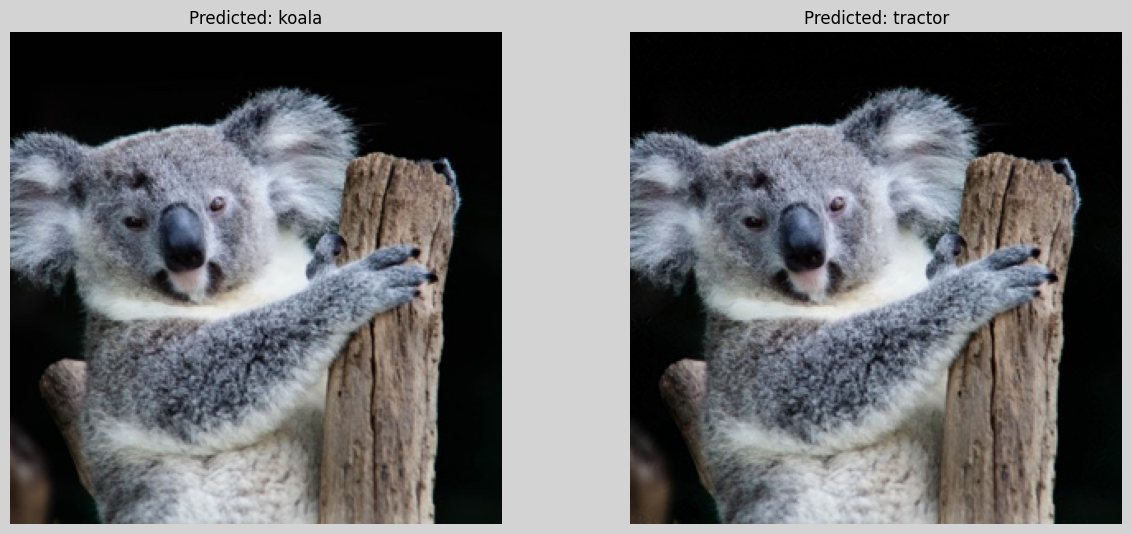

In [10]:
display_classifications([koala_image, poisoned_image])

## Defence measures

### Functions for the defence part

A part of the defence will involve training the model on new images. Here's the function we'll use for that.

In [11]:

def train(img, label):
    """Trains the model on an image.

    Parameters:
        - img: tensor of preprocessed image.
        - label: int target label for the image.
    """

    if len(img.shape) == 3:
        img = img.unsqueeze(0)

    # Define loss function and optimizer
    criterion = CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)

    # Set the model to training mode
    model.train()
    running_loss = 0.0

    # Prepare the input and label
    labels = torch.tensor([label])

    optimizer.zero_grad()
    outputs = model(img)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
    running_loss += loss.item()

    # print(f'Loss: {running_loss:.3f}')


We will also analyse the distributions of images to further our analysis.

In [12]:
def get_distribution(image):
    """Calculates and returns array of mean and std for each channel in image."""
    std, mean = torch.std_mean(image, axis=(1, 2))
    return tuple(mean.detach().numpy()) + tuple(std.detach().numpy())

### Preparations

First we will take a closer look at the adversarial noise. To do this, we will generate a number of images with differing noise strenghts.

Generating poisoned image..... attack image successful with noice strength 0.4
Generating poisoned image... attack image successful with noice strength 2.3000000000000003
Generating poisoned image... attack image successful with noice strength 4.4
Generating poisoned image... attack image successful with noice strength 6.500000000000001
Generating poisoned image... attack image successful with noice strength 8.6
Generating poisoned image... attack image successful with noice strength 10.7
Generating poisoned image.... attack image successful with noice strength 19.200000000000003
Generating poisoned image... attack image successful with noice strength 14.9
Generating poisoned image... attack image successful with noice strength 17.0
Generating poisoned image..... attack image successful with noice strength 38.2
Generating poisoned image.... attack image successful with noice strength 31.799999999999997
Generating poisoned image... attack image successful with noice strength 23.3
Genera

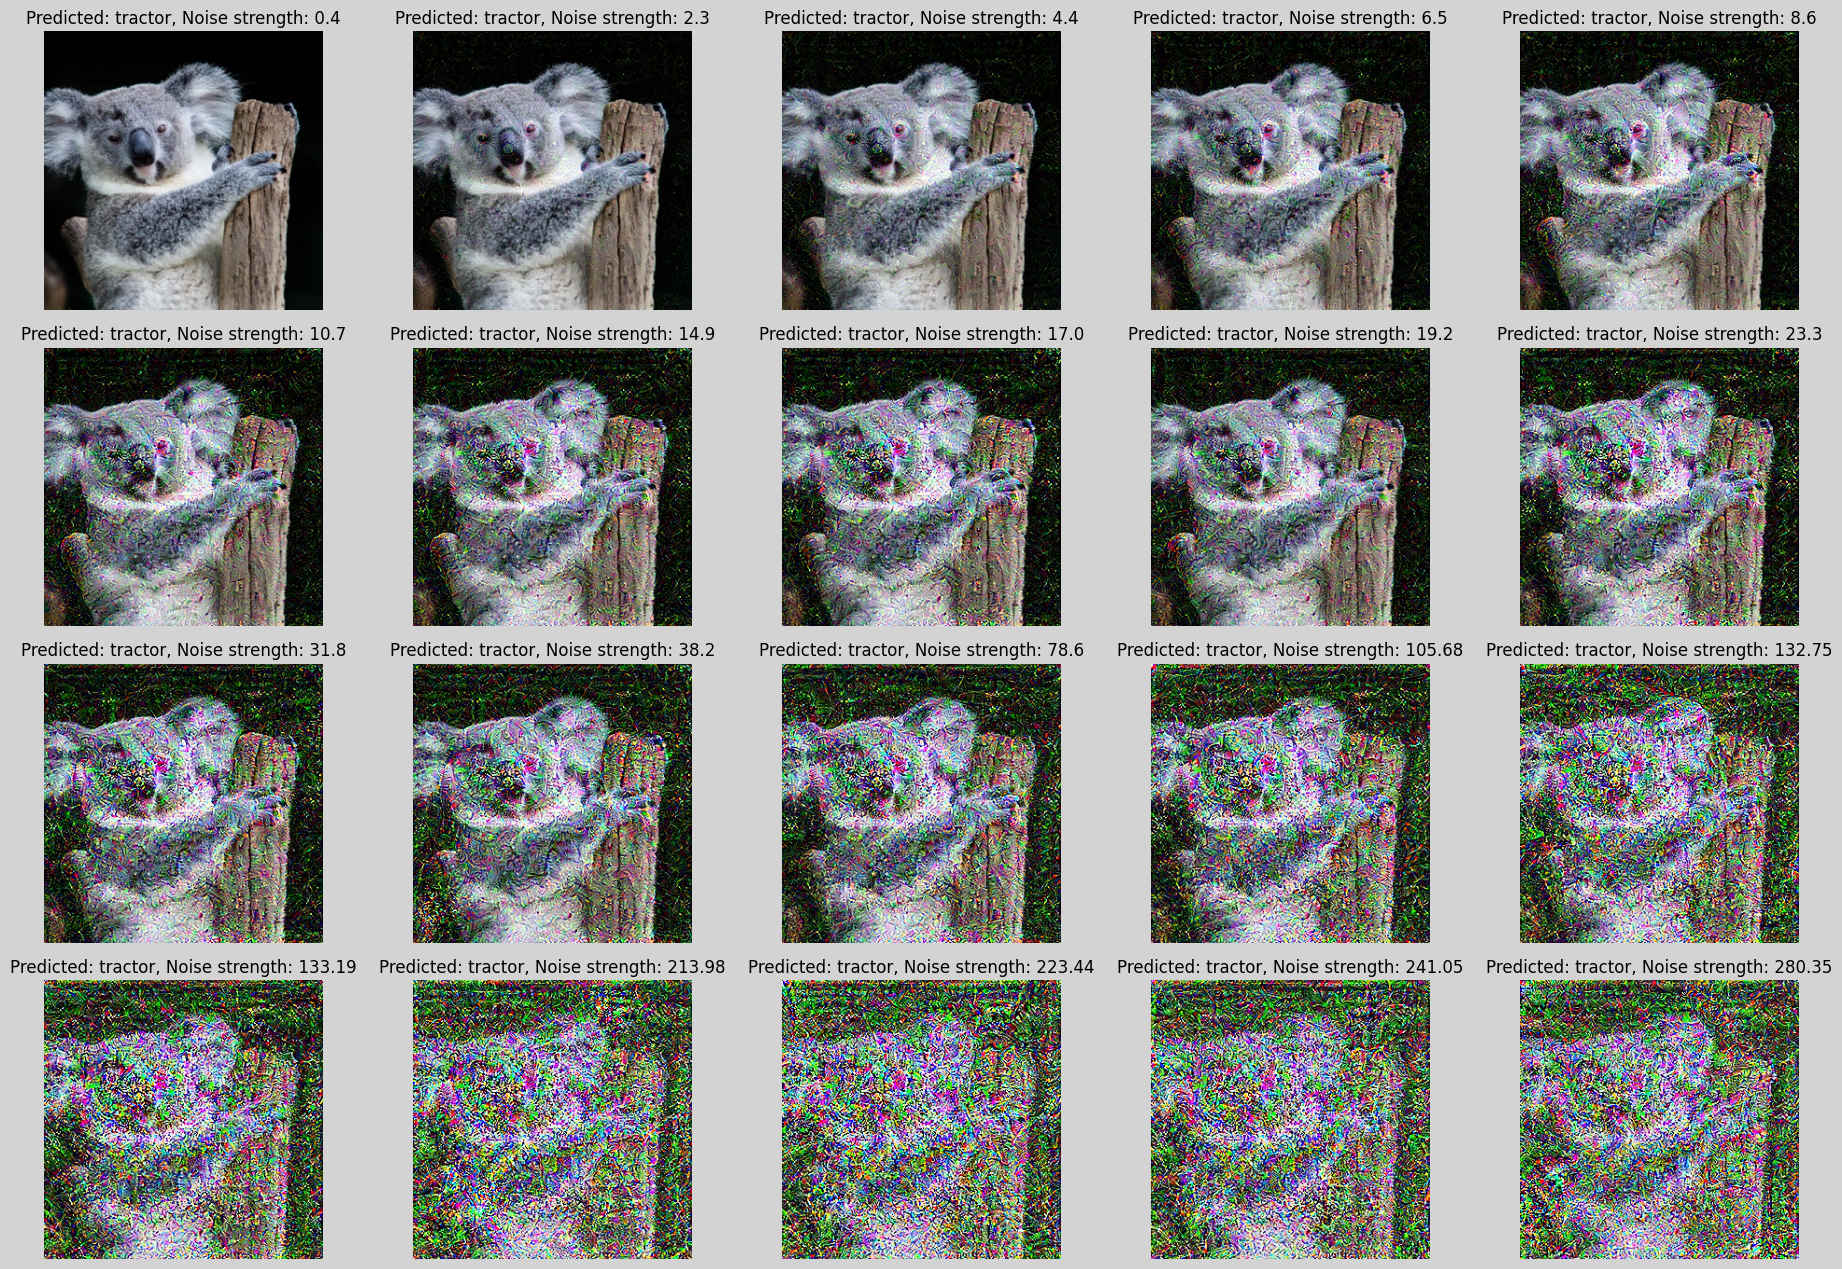

In [24]:

def generate_poisoned_data(n= 12, step_size_range = (0.1, 24), return_noise_strength= True, random_label= True):
    """Generates n poisoned images. Returns a tuple with a list of images and a list of noise strengths.

    Parameters:
        - n: Optional int number of images to generate. Default is 12.
        - step_size_range: Optional tuple with min/max values for step_size.
        - return_noise_strength: Optional bool whether to also return a list of the 
                                noise strengths for each image. True by default.        
        - random_label: Optional bool whether to use a random target label. If False, the label'tractor' 
                                will be used. True by default.
    """

    poisoned_data = []

    low = step_size_range[0]
    high = step_size_range[1]

    step_size_delta = (high - low) / n

    for i in range(n):

        step_size = low + step_size_delta * i

        if random_label:
            label = get_label(choice(id_to_label))
        else:
            label = tractor_label

        img, noise_strength = create_attack_image(koala_image, label, step_size, return_noise_strength= True)
        poisoned_data.append((img, noise_strength))

    poisoned_data.sort(key= lambda pair: pair[1])        # Sort by noise strength

    poisoned_images = [pair[0] for pair in poisoned_data]
    noise_strengths = [round(pair[1], 2) for pair in poisoned_data]

    if return_noise_strength:
        return poisoned_images, noise_strengths
    return poisoned_images

# Generate images with a wide range of noise strengths

poisoned_images, noise_strengths = generate_poisoned_data(12, (0.1, 12.7), random_label= False)
new_poisoned_images, new_noise_strengths = generate_poisoned_data(8, (13.1, 49.2), random_label= False)
poisoned_images.extend(new_poisoned_images)
noise_strengths.extend(new_noise_strengths)

noise_info = [f", Noise strength: {round(value, 2)}" for value in noise_strengths]
display_classifications(poisoned_images, extra_info= noise_info)


The noise remains subtle until we reach a noise strength of around 5. By the time the noise reaches 10, it's abundantly clear that the image has been altered, while higher values completely distort the image.

### Let's analyse the distribution of RGB values for poisoned images

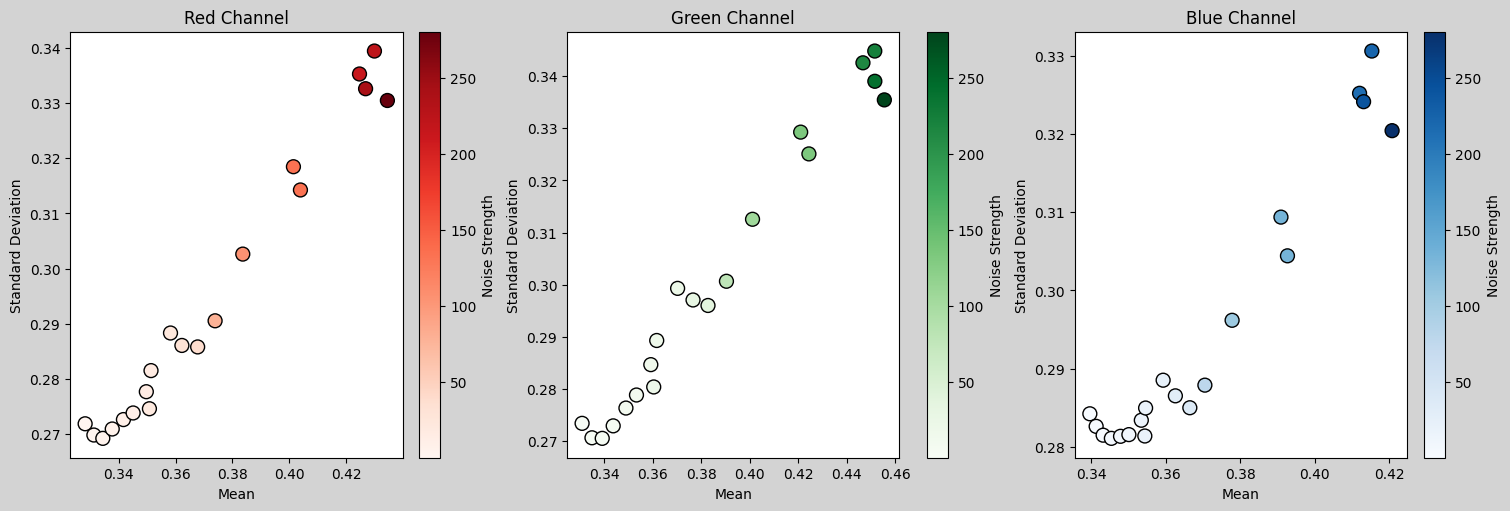

In [25]:

distributions = [get_distribution(img) for img in poisoned_images]

# Plot settings
channels = ["Red", "Green", "Blue"]
colors = ["Reds", "Greens", "Blues"]

fig, axes = plt.subplots(1, 3, figsize=(15, 5), constrained_layout=True)

for i, (channel, color) in enumerate(zip(channels, colors)):
    means = [dist[i] for dist in distributions]      # Extract means for the current channel
    stds = [dist[i + 3] for dist in distributions]  # Extract stds for the current channel
    ax = axes[i]
    scatter = ax.scatter(means, stds, c=noise_strengths, cmap=color, s=100, edgecolor='black')
    ax.set_title(f"{channel} Channel")
    ax.set_xlabel("Mean")
    ax.set_ylabel("Standard Deviation")
    ax.grid(False)
    fig.colorbar(scatter, ax=ax, label="Noise Strength")

fig.patch.set_facecolor("lightgray")

There are clear differences between the distributions of poisoned images given their noise strengths.

### Now we fit a Random Forest to detect the images with excessive noise.

We'll begin by putting together the dataset with the distributions, and adding a threshold that will determine whether the image has excessive noise or not.

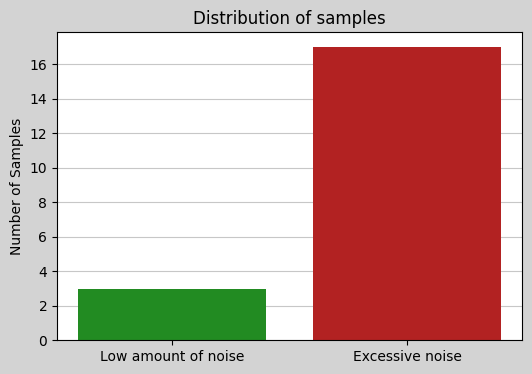

In [26]:

threshold = 6
distributions = [get_distribution(img) for img in poisoned_images]

labels = {0: "Low amount of noise", 1: "Excessive amount of noise"}
noise_detection_labels = [0 for _ in distributions]                         # Mark each data point as zero

for i, noise_strength in enumerate(noise_strengths):

    if noise_strength > threshold:
        noise_detection_labels[i] = 1                           # If the noise is above the threshold then change the label to 1

class_counts = [noise_detection_labels.count(0), noise_detection_labels.count(1)]

fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot()

ax.bar([0, 1], class_counts, color=["forestgreen", "firebrick"], width=0.8, zorder=2)
ax.grid(axis="y", alpha=0.7, zorder= 1)

# Add labels and title
ax.set_xticks([0, 1])
ax.set_xticklabels(["Low amount of noise", "Excessive noise"])
ax.set_ylabel("Number of Samples")
ax.set_title("Distribution of samples")
fig.patch.set_facecolor("lightgray")

### The defence

Here we train our model on the poisoned images, and then we fit the Random Forest to detect when there's heavy noise in the images.
It's important to limit the amount of noise we allow in the images we use for retraining the model; it still needs to resemble a koala.

In [17]:
max_noise_strength_for_training = 60

for image, noise_strength in zip(poisoned_images, noise_strengths):
    if noise_strength > max_noise_strength_for_training:
        continue
    train(image, get_label("koala"))

rf = RandomForestClassifier()
rf.fit(distributions, noise_detection_labels)

RandomForestClassifier()

### Results of the defence measure

The generation of adverserial images usually takes between 2-5 iterations. Now we will see that it will take much longer, and even then it may not achieve the desired classification. At this point, the random forest will try to determine whether it contains exessive noise or not. We will put a limit of 50 iterations for generating the poisoned image, but you can increase it if you like.

In [ ]:
# Feel free to change these parameters if you want to try more iterations or a higher step_size
max_iter = 50
step_size = 5           # Higher step size in order to speed up generation

poisoned_image = create_attack_image(koala_image, tractor_label, step_size= step_size, max_iter = max_iter)

poisoned_prediction = rf.predict([get_distribution(poisoned_image)])
koala_prediction = rf.predict([get_distribution(koala_image)])

display_classifications([koala_image, poisoned_image], extra_info= [", " + labels[koala_prediction[0]], ", " + labels[poisoned_prediction[0]]])

Generating poisoned image.................................................. attack image not successful despite noise strength of 250


In order to make this defence truly robust, one must generate adversarial images for all classes and train the model on those too. Otherwise model might learn to associate the noise with a certain class.

# Referenser

This work is inspired by the math taught in the multivariable calculus course and the various AI-courses on BTH.